# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [111]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [112]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [113]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [114]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


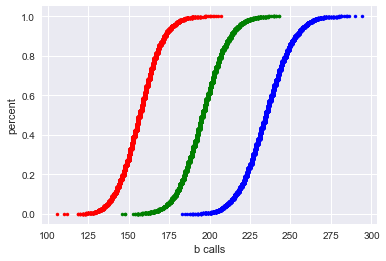

(array([   8.,   96.,  483., 1368., 2673., 2820., 1589.,  757.,  178.,
          28.]),
 array([0.02997947, 0.03197125, 0.03396304, 0.03595483, 0.03794661,
        0.0399384 , 0.04193018, 0.04392197, 0.04591376, 0.04790554,
        0.04989733]),
 <a list of 10 Patch objects>)

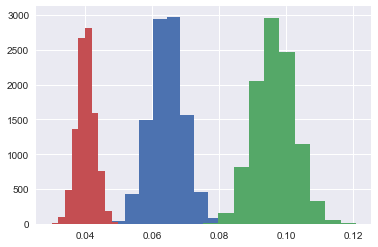

In [115]:
np.random.seed(42)

def ecdf(data):
    y=np.arange(1,len(data)+1)/len(data)
    x=np.sort(data)
    
    return x, y

# Take 10,000 samples out of the binomial distribution: n_defaults
n_defaults=np.random.binomial(n=len(data[data.race=='b']),p=data[['race','call']].groupby('race').describe()['call']['mean'][0],size=10000)
n_defaults2=np.random.binomial(n=len(data[data.race=='w']),p=data[['race','call']].groupby('race').describe()['call']['mean'][1],size=10000)
n_def3=np.random.binomial(n=len(data)/2,p=ratecomb,size=10000)
# Compute CDF: x, y
x,y=ecdf(n_defaults)
x1,y1=ecdf(n_defaults2)
x2,y2=ecdf(n_def3)
# Plot the CDF with axis labels
_=plt.plot(x,y,marker='.',linestyle='none',color='red')
_=plt.plot(x1,y1,marker='.',linestyle='none',color='blue')
_=plt.plot(x2,y2,marker='.',linestyle='none',color='green')
plt.xlabel('b calls')
plt.ylabel('percent')
# Show the plot
plt.show()
plt.hist(n_defaults/len(data[data.race=='b']))
plt.hist(n_defaults2/len(data[data.race=='w']))
plt.hist(n_def3/len(data))

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
The appropriate test is to get a distribution of the difference in means, in samples of permutated data, and to check the probability of getting our sample difference, given that both groups have the same call back rate. CLT applies when we resample the data many times to get a mean callback rate.


<p>The null hypothesis that the mean call back rate for both groups is the same.
The alternative hypothesis is that the mean call back rate for white names is higher than the mean call back rate for black sounding names.
</div>


In [116]:
data[['race','call']].groupby('race').describe()['call']['mean']
#call back rates per race
ratew=data[['race','call']].groupby('race').describe()['call']['mean'][1]
rateb=data[['race','call']].groupby('race').describe()['call']['mean'][0]
rate_diff=ratew - rateb
print(ratew,rateb,rate_diff)

0.09650924056768417 0.0644763857126236 0.03203285485506058


In [117]:
ratecomb=data.call.describe()['mean']
#callback rate for data set
print(ratecomb)

0.08049281686544418


In [118]:
#bootstrap assuming callback rate is same for whole data set
np.random.seed(42)


def bootstrap_replicate_1d(data,func):
    bs_sample=np.random.choice(data,len(data))
    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

pval: 0.0 , conf interval: [-0.02546201  0.01273101] , standard error: 0.00781081335668196


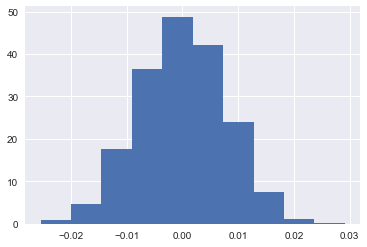

In [129]:
def diff_race(data):
    diffs = np.mean(data[:int(len(data)/2)]) - np.mean( data[int(len(data)/2):] )
    return diffs

newar6=draw_bs_reps(data['call'],diff_race,size=10000)
plt.hist(newar6, normed=True)
pval=np.sum(newar6>=rate_diff)/len(newar6)
confint=np.percentile(newar6,[0,95])
stanerr=np.std(newar6)
#margin of error, p value and confidence interval.
print("pval:",pval,", conf interval:",confint,", standard error:",stanerr)

In [130]:
stand_err=np.sqrt( (np.std(data[data.race=='b']['call']))**2 / int(len(data[data.race=='b'])) + (np.std(data[data.race=='w']['call']))**2 / int(len(data[data.race=='w'])) )
z_score=rate_diff/stand_err
pval=0
print("standard error:",stand_err, ", z_score:",z_score,", pval:",pval)
#conf interval at 95%, one tailed
print("conf interval:",stand_err*-3.4,stand_err*1.65 )

standard error: 0.007783308359923415 , z_score: 4.115583422082968 , pval: 0
conf interval: -0.02646324842373961 0.012842458793873635


np.sq

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
<p>Our data shows that there is a statistically different rate in call backs between resumes with white names and black names. More specifically, white name get called back at a higher rate.

<p>We cannot say that race is the most important factor in a callback. We would have to check all of the othe factors in order to determine which hold the most weight.
</div>